In this notebook, an implementation for the DQN algorithm takes place (hopefully)

install notes: 

pip install pytorch

pip install matplotlib

pip install gymnasium[classic_control]

In [1]:
# imports
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np


In [2]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The Algorithm we want to implement is Deep-Q learning with Experience Replay
The pseudocode outline of the Algorithm can be seen below:


&ensp;Initialize replay memory D to capacity N<br>
&ensp;Initialize action-value function Q with random weights<br>
&ensp;**for** episode = 1, M **do** <br>
&ensp;&ensp;&ensp; Initialise sequence $s1 = {x1}$ and preprocessed sequenced $\phi_1 = \phi(s1)$<br>
&ensp;&ensp;&ensp; **for** t = 1, T **do** <br>
&ensp;&ensp;&ensp;&ensp;&ensp; With probability $\epsilon$ select a random action $a_t$<br>
&ensp;&ensp;&ensp;&ensp;&ensp; otherwise select $a_t = max_a Q^*(\phi(s_t),a;\theta)$<br>
&ensp;&ensp;&ensp;&ensp;&ensp; Execute action $a_t$ in emulator and observe reward $r_t$ and image $x_{t+1}$<br>
&ensp;&ensp;&ensp;&ensp;&ensp; Set $s_{t+1} = s_t ,a_t ,x_{t+1}$ and preprocess $\phi_{t+1} = \phi(s_{t+1})$<br>
&ensp;&ensp;&ensp;&ensp;&ensp; Store transition $(\phi_t ,a_t,r_t,\phi_{t+1})$ in D<br>
&ensp;&ensp;&ensp;&ensp;&ensp; Sample random minibatch of transitions $(\phi_j , a_j, r_j, \phi_{j+1})$ from D<br>

&ensp;&ensp;&ensp;&ensp;&ensp;$
\text{Set} \ y = \begin{cases}
r_j, & \text{for terminal} \ \phi_{j+1} \\
r_j+\gamma \ max_{a^{'}}Q(\phi_{j+1}, a';\theta), & \text{for non-terminal } \ \phi_{j+1}
\end{cases}
$

&ensp;&ensp;&ensp;&ensp;&ensp;Perform a gradient descent step on $(y_j − Q(\phi_j, a_j; \theta))²$<br>
&ensp;&ensp;&ensp;**end for**<br>
&ensp;**end for**

The gradient descent step is given by:<br>
$\nabla_{\theta_i}L_i(\theta_i) = \mathbb{E}_{s, a \sim p(\cdot);s'\sim \epsilon} \big[\big(r+\gamma \max_{a'} Q(s', a';\theta_{i-1})-Q(s,a;\theta_i)\big)\nabla_{\theta_i}(s,a;\theta_i) \big]$

---

Notes: <br>
3 processes:<br>
- Process 1: Data Aquisition to fill buffer (latest Q function with some exploration)
- Process 2: Updates Target parameters (slower than Process 1 and 3, like every 10k iterations), copies $\phi$ into $\phi'$, with $\phi'$ being the current target
- Process 3: Actuall Training, fetch data from buffer, update our Q function $\phi$


---

In [55]:
# Constants and global variables
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
# BATCH_SIZE = 256
# CAPACITY = 10000 # Capacity of Replay Memory Buffer
CAPACITY = 10000 # Capacity of Replay Memory Buffer
GAMMA = 0.99
eps_start = 0.9 # Epsilon Greedy with decay rate based on steps taken for exploration
eps_end = 0.05
# EPS_DECAY = 1000
eps_decay = 1000 # Epsilon Greedy decay rate, varaible to be modified for each case
# TAU = 0.005 # Instead of doing a hard update from the policy network to the target network, we do a soft update every iteration
TAU = 0.001
LR = 1e-4

steps_done = 0
episode_durations = []
rewards_list = []

In [4]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
class DQN_old(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)
    
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_observations, 32),
            nn.ReLU(),
            nn.Linear(32,32),
            nn.ReLU(),
            nn.Linear(32,32), 
            nn.ReLU(),
            nn.Linear(32, n_actions)
        )

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


In [6]:
def select_action(env, policy_net, state, actions, cts = False, explore=True):
    global steps_done
    sample = random.random()
    eps_threshold = eps_end + (eps_start - eps_end) * \
        math.exp(-1. * steps_done / eps_decay)
    if not explore:
        eps_threshold = 0
    else:
        steps_done += 1
    if sample > eps_threshold: # Greedy
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else: # Exploration
        if cts:
            return torch.tensor([np.digitize(env.action_space.sample(), actions)], device=device, dtype=torch.long)
        else:
            return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [7]:
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 2:
        means = durations_t.unfold(0, 2, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(1), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [8]:
def plot_rewards(show_result=False):
    plt.figure(1)
    rewards_t = torch.tensor(rewards_list, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Rewards')
    # Take 100 episode averages and plot them too
    if len(rewards_t) >= 2:
        plt.plot(rewards_t.numpy())
        means = rewards_t.unfold(0, 2, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(1), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [9]:
# Plot learning Performance

def plot_learning(eval_epi_index, eval_freq, rewards, avg_returns, max_returns, min_returns, show_result=False):
    plt.figure(1)
    plt.clf()
    x = eval_epi_index

    plt.fill_between(x, min_returns, max_returns, alpha=0.1)
    plt.plot(x, avg_returns, '-o', markersize=1)

    plt.xlabel('Episode', fontsize=15)
    plt.ylabel('Return', fontsize=15)

    plt.title("DQN Learning Curve", fontsize=24)
    plt.pause(0.001)
    if not show_result:
        display.display(plt.gcf())
        display.clear_output(wait=True)
    else:
        display.display(plt.gcf())

$\nabla_{\theta_i}L_i(\theta_i) = \mathbb{E}_{s, a \sim p(\cdot);s'\sim \epsilon} \big[\big(r+\gamma \max_{a'} Q(s', a';\theta_{i-1})-Q(s,a;\theta_i)\big)\nabla_{\theta_i}(s,a;\theta_i) \big]$

we want to minimize: (loss_function): (the gradient of this equivalents to backpropagating the loss on the network)

$(y_j − Q(\phi_j, a_j; \theta))²$

where

$
\text{Set} \ y = \begin{cases}
r_j, & \text{for terminal} \ \phi_{j+1} \\
r_j+\gamma \ max_{a^{'}}Q(\phi_{j+1}, a';\theta), & \text{for non-terminal } \ \phi_{j+1}
\end{cases}
$




In [10]:
def loss_function(Q_values, target_Q_values, rewards, done, actions):
    # Calculate the target values
    if done:
        y = rewards
    else:
        y = rewards + GAMMA * torch.max(target_Q_values, dim=-1)[0] 

    # Calculate the temporal difference error
    TD_error = y - Q_values
    # Square the TD error
    squared_TD_error = TD_error ** 2

    # Calculate the mean squared TD error
    loss = torch.mean(squared_TD_error)

    return loss

In [61]:
def optimize_model(policy_net, target_net, optimizer, memory):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute loss
    # loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    loss = loss_function(state_action_values, expected_state_action_values.unsqueeze(1), reward_batch, 0, action_batch)

    # Optimize the model, i.e. gradient update
    optimizer.zero_grad() # Practicality dictates that we zero the gradients before backpropagation
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 1)
    # torch.nn.utils.clip_grad_value_(policy_net.parameters(), 50) # worked decent on CartPole
    # torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [50]:
def train_model(env, num_episodes, policy_net, target_net, memory, optimizer, actions, device, eval_freq, cts=False):
    avg_returns = []
    max_returns = []
    min_returns = []
    eval_epi_index = []
    
    for i_episode in range(num_episodes+1):
        # Initialize the environment and get its state
        total_reward = 0
        state, info = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

        for t in count():
            action = select_action(env, policy_net, state, actions, cts) 
            # action = select_action(env, target_net, state, actions, cts) # We sample environment with older network, aka target net
            # print(action.item())
            if cts:
                observation, reward, terminated, truncated, _ = env.step([actions[action.item()]])
            else:
                observation, reward, terminated, truncated, _ = env.step(action.item())

            # env.render()
            total_reward+=reward
            reward = torch.tensor([reward], device=device)
            done = terminated or truncated
            
            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in memory
            memory.push(state, action, next_state, reward)
                
            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            optimize_model(policy_net, target_net, optimizer, memory)


            # Soft update of the target network's weights, instead of hard update every X iterations
            # θ′ ← τ θ + (1 −τ )θ′
            # target_net_state_dict = target_net.state_dict()
            # policy_net_state_dict = policy_net.state_dict()
            # for key in policy_net_state_dict:
            #     target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            # target_net.load_state_dict(target_net_state_dict)

            if done:
                # print(f"Total reward: {total_reward}")
                episode_durations.append(t + 1)
                rewards_list.append(total_reward)
                # plot_durations()
                # plot_rewards()
                break
        
        if i_episode % (1/TAU/5) == 0:
            # print(f"Episode : {i_episode} hardupdate")
            target_net.load_state_dict(policy_net.state_dict())
            all_reward = []
            for i in range(20):
                # run trained model and print average reward over the 5 episodes
                state, info = env.reset()
                state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
                total_reward = 0
                for t in count():
                    action = select_action(env, target_net, state, env.action_space, cts=False, explore=False)
                    # action = select_action(env, policy_net, state, env.action_space, cts=False, explore=False)
                    if cts:
                        observation, reward, terminated, truncated, _ = env.step([actions[action.item()]])
                    else:
                        observation, reward, terminated, truncated, _ = env.step(action.item())
                    total_reward += reward
                    if terminated or truncated:
                        break
                    state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
                all_reward.append(total_reward)
            avg_returns.append(np.mean(all_reward, axis=0))
            max_returns.append(np.max(all_reward, axis=0))
            min_returns.append(np.min(all_reward, axis=0))
            eval_epi_index.append(i_episode+1)
        
        if (i_episode+1) % eval_freq == 0 and i_episode > 1:
            
            # rewards = rewards_list[((i_episode+1)-eval_freq+1):(i_episode+1)]
            # avg_returns.append(np.mean(rewards, axis=0))
            # max_returns.append(np.max(rewards, axis=0))
            # min_returns.append(np.min(rewards, axis=0))
            # eval_epi_index.append(i_episode+1)
            plot_learning(eval_epi_index, eval_freq, all_reward, avg_returns, max_returns, min_returns)

    print('Complete')
    plot_rewards(show_result=True)
    plot_learning(eval_epi_index, eval_freq, rewards_list, avg_returns, max_returns, min_returns, show_result=True)
    plt.ioff()
    plt.show()

First environment: Mountain Car
---

Action Space: Discrete (3)

Observation Space: Box([-1.2 -0.07], [0.6 0.07], (2,), float32)

In [62]:
env = gym.make("MountainCar-v0")
steps_done = 0
episode_durations = []
rewards_list = []

eps_decay = 50000 # Mountain-car needs alot of exploration as only the target state gives a different reward
eps_start = 0.9 # Epsilon Greedy with decay rate based on steps taken for exploration
eps_end = 0.05

num_episodes = 1000 # number of training iterations
eval_freq = 20 # sumarize trained episodes frequency

# Get the number of state observations
state, info = env.reset()
n_observations = len(state)
n_actions = env.action_space.n

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(CAPACITY)

# call the train_function, move everything below into callable functions

train_model(env, num_episodes, policy_net, target_net, memory, optimizer, env.action_space, device, eval_freq, cts=False)
torch.save(policy_net.state_dict(), f"DQN_policy_net_Mountaincar.pt") # look at what to save in the end
torch.save(target_net.state_dict(), f"DQN_target_net_Mountaincar.pt") # look at what to save in the end

RuntimeError: index 1 is out of bounds for dimension 1 with size 1

In [ ]:
# Load target net
env = gym.make("MountainCar-v0")
steps_done = 0
episode_durations = []

# Get the number of state observations
state, info = env.reset()
n_observations = len(state)
n_actions = env.action_space.n

target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(torch.load("DQN_policy_net_Mountaincar.pt"))

In [ ]:
# Good Plotting for non-Linux-nerds

env = gym.make("MountainCar-v0", render_mode='human')

# run trained model on environment
state, info = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
for t in count():
    action = select_action(env, target_net, state, env.action_space, cts=False, explore=False)
    observation, reward, terminated, truncated, _ = env.step(action.item())
    env.render()
    if terminated or truncated:
        break
    state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
env.close()

In [ ]:
env = gym.make("MountainCar-v0")
all_reward = []
for i in range(5):
    # run trained model and print average reward over the 5 episodes
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    total_reward = 0
    for t in count():
        action = select_action(env, target_net, state, env.action_space, cts=False, explore=False)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        total_reward += reward
        if terminated or truncated:
            break
        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
    all_reward.append(total_reward)
env.close()
print(all_reward)
print(sum(all_reward)/len(all_reward))

Second environment: Cartpole
---

Action Space: Discrete (2)

Observation Space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

Complete


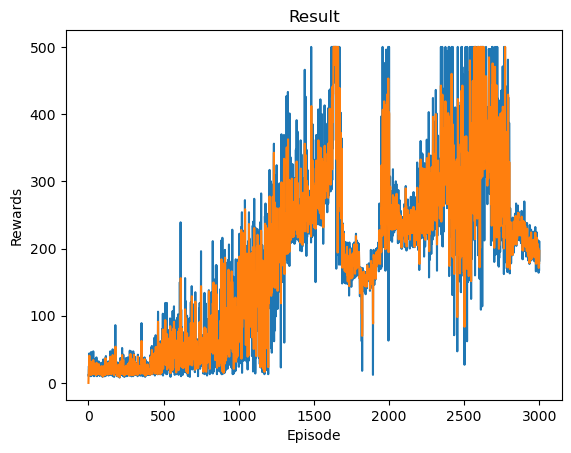

<Figure size 640x480 with 0 Axes>

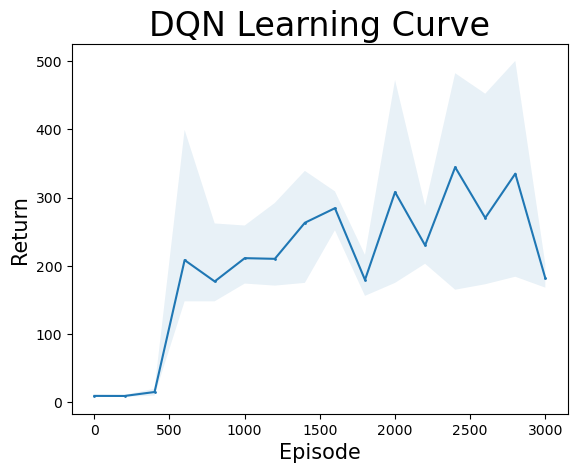

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [51]:
env = gym.make("CartPole-v1")
steps_done = 0
episode_durations = []
rewards_list = []

eps_decay = 50000 # Mountain-car needs alot of exploration as only the target state gives a different reward
eps_start = 0.9 # Epsilon Greedy with decay rate based on steps taken for exploration
# eps_end = 0.05
eps_end = 0.05

num_episodes = 3000 # number of training iterations
eval_freq = 20 # sumarize trained episodes frequency

# Get the number of state observations
state, info = env.reset()
n_observations = len(state)
n_actions = env.action_space.n

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(CAPACITY)

# call the train_function, move everything below into callable functions

train_model(env, num_episodes, policy_net, target_net, memory, optimizer, env.action_space, device, eval_freq, cts=False)
torch.save(policy_net.state_dict(), f"DQN_policy_net_Cartpole.pt") # look at what to save in the end
torch.save(target_net.state_dict(), f"DQN_target_net_Cartpole.pt") # look at what to save in the end

In [ ]:
# Load target net
env = gym.make("CartPole-V1")
steps_done = 0
episode_durations = []

# Get the number of state observations
state, info = env.reset()
n_observations = len(state)
n_actions = env.action_space.n

target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(torch.load("DQN_policy_net_Cartpole.pt"))

In [ ]:
# Good Plotting for non-Linux-nerds

env = gym.make("CartPole-V1", render_mode='human')

# run trained model on environment
state, info = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
for t in count():
    action = select_action(env, target_net, state, env.action_space, cts=False, explore=False)
    observation, reward, terminated, truncated, _ = env.step(action.item())
    env.render()
    if terminated or truncated:
        break
    state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
env.close()

In [27]:
env = gym.make("CartPole-v1")
all_reward = []
for i in range(2000):
    # run trained model and print average reward over the 5 episodes
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    total_reward = 0
    for t in count():
        action = select_action(env, target_net, state, env.action_space, cts=False, explore=False)
        # action = select_action(env, policy_net, state, env.action_space, cts=False, explore=False)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        total_reward += reward
        if terminated or truncated:
            break
        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
    all_reward.append(total_reward)
env.close()
print(f"Max Reward: {max(all_reward)}, Min Reward: {min(all_reward)}, Average Reward: {sum(all_reward)/len(all_reward)}")

Max Reward: 233.0, Min Reward: 162.0, Average Reward: 189.3445


Third enviroment: pendulum
--

Action Space: Box(-2.0, 2.0, (1,), float32)

Observation Space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)


Complete


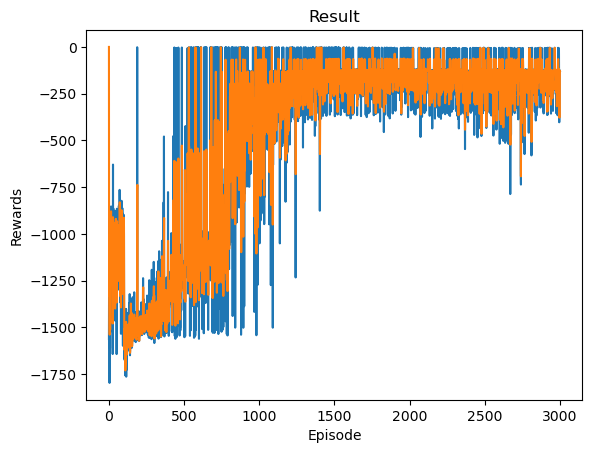

<Figure size 640x480 with 0 Axes>

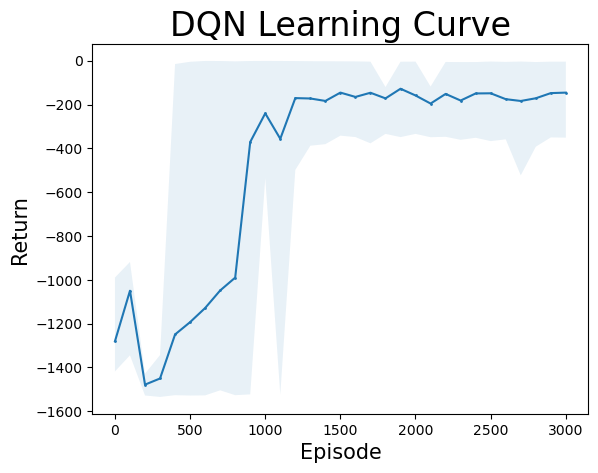

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [42]:
env = gym.make("Pendulum-v1")
steps_done = 0
episode_durations = []
rewards_list = []

eps_decay = 10000 # Pendulum needs less exploration
eps_start = 0.9 # Epsilon Greedy with decay rate based on steps taken for exploration
eps_end = 0.05

num_episodes = 3000 # number of training iterations
eval_freq = 20 # sumarize trained episodes frequency

# Discretized Action Space
action_range = (env.action_space.low[0], env.action_space.high[0])
n_actions = 31
actions = np.linspace(action_range[0], action_range[1], n_actions)

# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(CAPACITY)

# call the train_function, move everything below into callable functions

train_model(env, num_episodes, policy_net, target_net, memory, optimizer, actions, device, eval_freq, cts=True)
torch.save(policy_net.state_dict(), f"DQN_policy_net_Pendulum.pt") # look at what to save in the end
torch.save(target_net.state_dict(), f"DQN_target_net_Pendulum.pt") # look at what to save in the end

In [ ]:
# Load target net
env = gym.make("Pendulum-v1")
steps_done = 0
episode_durations = []

# Discretized Action Space
action_range = (env.action_space.low[0], env.action_space.high[0])
n_actions = 10
actions = np.linspace(action_range[0], action_range[1], n_actions)

# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(torch.load("DQN_policy_net_Pendulum.pt"))

In [ ]:
# Good Plotting for non-Linux-nerds
env = gym.make("Pendulum-v1", render_mode='human')
# run trained model on environment
state, info = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
for t in count():
    action = select_action(env, target_net, state, actions, cts=True, explore=False)
    observation, reward, terminated, truncated, _ = env.step([actions[action.item()]])
    env.render()
    if terminated or truncated:
        break
    state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
env.close()

In [44]:
env = gym.make("Pendulum-v1")
all_reward = []
for i in range(2000):
    # run trained model and print average reward over the 5 episodes
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    total_reward = 0
    for t in count():
        action = select_action(env, target_net, state, actions, cts=True, explore=False)
        observation, reward, terminated, truncated, _ = env.step([actions[action.item()]])
        total_reward += reward
        if terminated or truncated:
            all_reward.append(total_reward)
            break
        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
    # print(f"Episode {i+1} Reward: {total_reward}")
env.close()
print(f"Average Reward: {sum(all_reward)/len(all_reward)}")
print(f"Max reward: {max(all_reward)}, Min reward: {min(all_reward)}")

Average Reward: -161.77878811408297
Max reward: -3.7291114080533982, Min reward: -476.3849711666589
